In [1]:
import ast
import math
import time
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython import display

In [2]:
with open('maze.txt') as f:
    maze_ad = np.array(ast.literal_eval(f.read()))

In [3]:
maze_ad

array([[1., 1., 0., 0.],
       [0., 1., 1., 0.],
       [1., 1., 0., 0.],
       [1., 0., 1., 0.],
       [1., 0., 1., 0.],
       [1., 1., 1., 0.],
       [1., 0., 1., 0.],
       [1., 0., 1., 0.],
       [1., 0., 1., 0.],
       [0., 1., 1., 0.],
       [0., 1., 0., 1.],
       [1., 0., 0., 1.],
       [1., 0., 1., 1.],
       [0., 0., 1., 0.],
       [1., 1., 0., 0.],
       [0., 0., 1., 1.],
       [1., 1., 0., 0.],
       [1., 0., 1., 0.],
       [1., 0., 1., 0.],
       [0., 0., 1., 1.],
       [1., 1., 0., 1.],
       [0., 0., 1., 0.],
       [1., 1., 0., 0.],
       [1., 1., 1., 0.],
       [0., 0., 1., 1.],
       [1., 0., 0., 0.],
       [0., 1., 1., 1.],
       [1., 1., 0., 0.],
       [1., 1., 1., 0.],
       [0., 1., 1., 0.],
       [0., 1., 0., 1.],
       [1., 1., 0., 0.],
       [0., 0., 1., 1.],
       [0., 0., 0., 1.],
       [1., 1., 0., 0.],
       [0., 1., 1., 0.],
       [0., 1., 0., 1.],
       [0., 0., 0., 1.],
       [0., 1., 0., 1.],
       [0., 0., 0., 1.],


In [4]:
def delta(idx) -> tuple[int, int]:
    return [(0, 1), (1, 0), (0, -1), (-1, 0)][idx]

def c_to_i(x, y, size) -> int:
    return x * size + y

def i_to_c(i, size) -> tuple[int, int]:
    return i // size, i % size

def move(s: int, a: int, size: int, ad) -> int:
    if ad[s, a] == 0:
        return s
    x, y = i_to_c(s, size)
    dx, dy = delta(a)
    return c_to_i(min(max(x + dx, 0), size - 1), min(max(y + dy, 0), size - 1), size)

def state_valid(x: int, y: int, size: int) -> bool:
    return (0 <= x < size) and (0 <= y < size)

In [5]:
def make_diagram(ad):
    maze_diagram = np.zeros([size * 2 + 1, size * 2 + 1])
    for i in range(maze_ad.shape[0]):
        x, y = i_to_c(i, size)
        x_, y_ = 2 * x + 1, 2 * y + 1
        maze_diagram[x_, y_] = 1
        for j in range(4):
            if maze_ad[i, j] == 1:
                dx, dy = delta(j)
                maze_diagram[x_ + dx, y_ + dy] = 1

    in_x, in_y = size // 2, 0
    out_x, out_y = size // 2, size - 1
    maze_diagram[in_x * 2 + 1, in_y * 2] = 1
    maze_diagram[out_x * 2 + 1, out_y * 2 + 2] = 1
    return maze_diagram

def show_diagram(ad):
    plt.matshow(make_diagram(ad))

def show_Q(ad, Q_in):
    Q = Q_in.copy()
    maze = make_diagram(ad)
    for s in range(Q.shape[0]):
        x, y = i_to_c(s, size)
        # maze[x * 2 + 1, y * 2 + 1] = np.mean(Q[s, :])
        Q[s, :] = np.exp(Q[s, :]) * ad[s, :]
        print(Q[s,:], (Q[s, :] - Q[s, :].min()) / (Q[s, :].max() - Q[s, :].min()))
        Q[s, :] = (Q[s, :] - Q[s, :].min()) / (Q[s, :].max() - Q[s, :].min()) #* ad[s, :]
        for a in range(Q.shape[1]):
            dx, dy = delta(a)
            # if not (0 <= x + dx < size) or not (0 <= y + dy < size):
            #     continue
            maze[x * 2 + 1 + dx, y * 2 + 1 + dy] = Q[s, a]

    # display.clear_output(wait=True)
    # display.display(plt.gcf())
    sns.heatmap(maze)
    plt.show()

In [6]:
alpha = 0.3
gamma = 0.3
epsilon = 0.1

n_states = maze_ad.shape[0]
goal_state = n_states - 1
size = int(math.sqrt(n_states))
n_actions = 4

Q_init = maze_ad.copy() * 0.01 
# Q_init = np.zeros([n_states, n_actions])
# R_init = np.zeros(n_states)
# R_init = maze_ad.sum(axis=1) - 1  # The more junctions, the better
# R_init[maze_ad.sum(axis=1) <= 1] = -1  # Avoid dead ends
# R_init[goal_state] = 100  # Promote the exit

R_init = (maze_ad.copy() - 1) * 99 - 1
for a in range(4):
    dx, dy = delta(a)
    x, y = i_to_c(goal_state, size)
    x_ = x - dx
    y_ = y - dy
    if not state_valid(x_, y_, size):
        continue
    origin_state = c_to_i(x_, y_, size)
    R_init[origin_state, a] = 10

s_init = 0
R_min = -100

In [14]:
def play_episode(Q, R, epsilon):
    s_t = s_init
    t = 0
    r_t = 0

    while s_t != n_states - 1 and r_t > R_min:
    # for _ in range(100000):
        # R_a = maze_ad[s_t, :] * np.exp(Q[s_t, :])
        # probs = R_a / R_a.sum()
        # a_max = np.random.choice(np.arange(4), [], p=probs)
        if random.random() < epsilon:
            # a_max = np.random.choice(np.arange(4), [], p=maze_ad[s_t, :] / maze_ad[s_t, :].sum())
            
            a_max = np.random.choice(np.arange(4), [])
        else:
            # print(np.exp(Q[s_t, :]) * maze_ad[s_t, :], np.argmax(np.exp(Q[s_t, :]) * maze_ad[s_t, :]))
            a_max = np.argmax(Q[s_t, :])

        # if maze_ad[s_t, a_max] == 0:
        #     continue
        
        # print(s_t, i_to_c(s_t, size), a_max) 
        s_t1 = move(s_t, a_max, size, maze_ad)
        r_t = r_t + R[s_t, a_max]
        Q[s_t, a_max] = (1. - alpha) * Q[s_t, a_max] \
            + alpha * r_t \
            + alpha * gamma * max([Q[s_t1, a] for a in range(4)])

        s_t = s_t1
        # R[s_t1] = 0
        t += 1
        # print(Q.round(0))
        if t > 5 and False:
            time.sleep(1000)
        # show_Q(maze_ad, Q)
        # time.sleep(.1)
    print(t, s_t == n_states - 1)
    return Q

In [19]:
Q = Q_init.copy()
for i in range(100):
    Q_new = play_episode(Q.copy(), R_init.copy(), 0.1)
    # show_Q(maze_ad, Q_new)
    # print(np.abs((Q - Q_new).mean()))
    Q = Q_new
    time.sleep(.1)
# Q = play_episode(Q, R_init.copy())
# show_Q(maze_ad, Q)
# Q = play_episode(Q, R_init.copy())
# show_Q(maze_ad, Q)
# Q = play_episode(Q, R_init.copy())
# show_Q(maze_ad, Q)
# Q = play_episode(Q, R_init.copy())
# show_Q(maze_ad, Q)

3 False
4 False
1 False
1 False
6 False
2 False
2 False
8 False
3 False
8 False
2 False
11 False
1 False
8 False
18 False
4 False
5 False
7 False
4 False
13 False
25 False
17 False
6 False
19 False
4 False
13 False
5 False
5 False
27 False
17 False
44 False
17 False
14 False
15 False
47 False
17 False
34 False
4 False
2 False
10 False
8 False
3 False
16 False
8 False
6 False
6 False
34 False
3 False
13 False
17 False
5 False
34 False
34 False
60 False
2 False
31 False
2 False
7 False
7 False
2 False
2 False
7 False
23 False
11 False
3 False
2 False
7 False
14 False
13 False
45 False
5 False
3 False
12 False
7 False
11 False
23 False
8 False
49 False
16 False
5 False
5 False
35 False
24 False
3 False
21 False
23 False
40 False
44 False
19 False
7 False
17 False
41 False
51 False
40 False
25 False
15 False
22 False
12 False
41 False
2 False


[9.49905705e-02 6.98788253e-33 0.00000000e+00 0.00000000e+00] [1.000000e+00 7.356396e-32 0.000000e+00 0.000000e+00]
[0.00000000e+00 2.05793300e-02 1.05634599e-33 0.00000000e+00] [0.00000000e+00 1.00000000e+00 5.13304364e-32 0.00000000e+00]
[9.18696430e-05 6.89029447e-33 0.00000000e+00 0.00000000e+00] [1.00000000e+00 7.50007755e-29 0.00000000e+00 0.00000000e+00]
[6.51493829e-06 0.00000000e+00 4.12262281e-31 0.00000000e+00] [1.00000000e+00 0.00000000e+00 6.32795374e-26 0.00000000e+00]
[2.08385216e-07 0.00000000e+00 5.68454487e-27 0.00000000e+00] [1.0000000e+00 0.0000000e+00 2.7279022e-20 0.0000000e+00]
[2.37497959e-20 1.59191283e-20 3.02455633e-20 0.00000000e+00] [0.78523239 0.52632937 1.         0.        ]
[2.59373878e-20 0.00000000e+00 7.05147189e-20 0.00000000e+00] [0.36782942 0.         1.         0.        ]
[2.66656986e-19 0.00000000e+00 1.52326596e-18 0.00000000e+00] [0.17505609 0.         1.         0.        ]
[3.44694374e-16 0.00000000e+00 1.68882998e-15 0.00000000e+00] [0.204

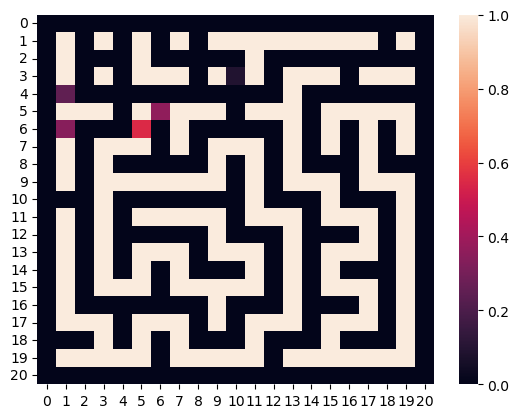

In [9]:
show_Q(maze_ad, Q)

In [17]:
Q.max(axis=1).round(0)
# R_init

array([ -87., -121.,  -86.,  -73.,  -57.,  -33.,   -6.,    0.,    0.,
          0.,  -98., -113., -101.,  -97.,    0.,  -18.,    0.,    0.,
          0.,    0., -100., -132.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0., -126.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0., -131.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.])

In [78]:
maze_ad

array([[0., 1., 0., 0.],
       [1., 1., 0., 0.],
       [1., 1., 1., 0.],
       [0., 1., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 1.],
       [0., 0., 1., 1.],
       [0., 1., 0., 1.],
       [0., 1., 0., 1.],
       [0., 1., 0., 1.],
       [0., 1., 0., 0.],
       [1., 1., 0., 0.],
       [0., 0., 1., 1.],
       [0., 1., 0., 1.],
       [0., 1., 0., 1.],
       [0., 1., 0., 1.],
       [0., 1., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 1.],
       [0., 1., 1., 1.],
       [1., 0., 0., 1.],
       [0., 0., 1., 1.],
       [1., 0., 0., 1.],
       [1., 0., 1., 0.],
       [0., 0., 1., 1.]])